[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/data-mining/sentiment-analysis/sentiment-analysis.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/data-mining/sentiment-analysis/sentiment-analysis.ipynb)

# Sentiment Analysis with Pinecone

**Use cases**: customer feedback analysis, social media monitoring, brand reputation management, market research, product development, political campaign analysis, movie or restaurant reviews, customer support ticket analysis, employee feedback analysis, e-commerce product reviews, healthcare patient sentiment analysis

Sentiment analysis, often known as opinion mining, is a technique used in natural language processing (NLP) to determine the emotional undertone of a text. This is a common method used by organizations to identify and group opinions about their product, service, and ideas. In this notebook, we will apply this technique to the hotel industry and understand customer perception and potential areas that need improvement. To do this, we will:

1.	Generate Sentiment labels and scores based on customer reviews.
2.	Store them in a Pinecone index as metadata (alongside respective text vectors).
3.	Query Pinecone index on selected areas and understand customer opinions.

Let's get started.


# Install Dependencies

1. **sentence_transformers**: Generates numerical representations (embeddings) of text for NLP tasks.
   
2. **pinecone-client**: A client for Pinecone, a service for efficient vector similarity searches.

3. **datasets**: Simplifies access to various machine learning datasets for research.

4. **seaborn**: A high-level data visualization library for creating attractive statistical graphics.

5. **matplotlib**: A powerful data visualization library for creating charts, plots, and graphs in Python.

In [ ]:
!pip install sentence_transformers pinecone-client datasets seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.4 MB/s eta 0:0

# Load and Prepare Dataset

We use a dataset containing ~90k hotel reviews provided by customers. This dataset can be loaded from the HuggingFace dataset hub as follows:

In [ ]:
from datasets import load_dataset

# load the dataset and convert to pandas dataframe
df = load_dataset(
    "ashraq/hotel-reviews",
    split="train"
).to_pandas()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/93757 [00:00<?, ? examples/s]

In [ ]:
df.head()

,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...


In [ ]:
# keep only the first 800 characters from the reviews
df["review"] = df["review"].str[:800]
# glimpse the dataset
df.head()

,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...


# Initialize Sentiment Analysis Model

We will use a RoBERTa model fine-tuned for sentiment analysis to analyze the hotel reviews. The model can be loaded from the HuggingFace model hub as follows:

In [ ]:
import torch

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

model_id = "cardiffnlp/twitter-roberta-base-sentiment"

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
    )

The sentiment analysis model returns `LABEL_0` for negative, `LABEL_1` for neutral and `LABEL_2` for positive labels. We can add them to a dictionary to easily access them when showing the results.

In [ ]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [ ]:
# view review number 241
test_review = df["review"][241]
test_review

' Room was small for a superior room and poorly lit especially as it was an inside room and overlooked the inside wall of the hotel No view therefore needed better lighting within Restaurant tables were not well laid and had to go searching for cutlery at breakfast '

In [ ]:
# get the sentiment label and score for review number 241
nlp(test_review)

[{'label': 'LABEL_0', 'score': 0.7736574411392212}]

Our pipeline is working as expected and accurately predicts the correct label for the review.

# Initialize Retriever

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:

In [ ]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

# Initialize Pinecone Index

Now we need to initialize our Pinecone index. The Pinecone index stores vector representations of our passages which we can retrieve using another vector (the query vector). We first need to initialize our connection to Pinecone. For this, we need a free [API key](https://app.pinecone.io/), we initialize the connection like so:

In [ ]:
import pinecone

# connect to pinecone environment
pinecone.init(
    api_key="52865541-2519-4196-8238-17f33a89296d",
    environment="asia-southeast1-gcp-free"  # find next to API key in console
)

Now we can create our vector index. We will name it `sentiment-mining` (feel free to choose any name you prefer). We specify the metric type as `cosine` and dimension as `384` as these are the vector space and dimensionality of the vectors generated by the retriever model.

In [ ]:
index_name = "sentiment-mining"

# check if the sentiment-mining index exists
if index_name not in pinecone.list_indexes():
    # create the index if it does not exist
    pinecone.create_index(
        index_name,
        dimension=384,
        metric="cosine"
    )

# connect to sentiment-mining index we created
index = pinecone.Index(index_name)

# Generate Embeddings and Upsert

We generate embeddings for all the reviews in the dataset. Alongside the embeddings, we also include the sentiment label and score in the Pinecone index as metadata. Later we will use this data to understand customer opinions.

Let's first write a helper function to generate sentiment labels and scores for a batch of reviews.

In [ ]:
def get_sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [ ]:
# get sentiment labels for few reviews
get_sentiment(df["review"][:3].tolist())

(['negative', 'neutral', 'positive'],
 [0.9065250754356384, 0.7716172933578491, 0.8975034952163696])

We need to convert the review dates to timestamps to filter query results for a given period. This is helpful if you want to understand customer sentiment over a specific period. Let's write another helper function to convert dates to timestamps.

In [ ]:
import dateutil.parser

# convert date to timestamp
def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

In [ ]:
get_timestamp([df["review_date"][0]])[0]

1501718400.0

Now we create the embeddings. We do this in batches of `64` to avoid overwhelming machine resources or API request limits.

Explanation of the code below:

1. Importing the `tqdm` library: The code begins by importing the `tqdm.auto` module. `tqdm` is a Python library used to display progress bars for tasks that take a long time to complete.

2. Setting the batch size: A batch size of 64 is defined, which means that the data will be processed in chunks of 64 records at a time. This is a common technique to efficiently handle large datasets.

3. Looping through the data in batches: The code enters a `for` loop that iterates over the data in batches of size 64. It uses the `tqdm` function to display a progress bar to track the loop's progress.

4. Extracting a batch: Inside the loop, it calculates the start and end indices (`i` and `i_end`) for the current batch. It then extracts a batch of data from the DataFrame `df` using these indices.

5. Generating embeddings: The code appears to be using some kind of retriever (not shown in this snippet) to generate embeddings (vector representations) for the text reviews in the current batch. These embeddings are computed from the text data and converted to a list.

6. Timestamp conversion: It looks like there is a function called `get_timestamp` that is used to convert the "review_date" column in the batch to timestamps. This likely enables time-based filtering or sorting later on.

7. Adding sentiment information: There seems to be a function called `get_sentiment` that is used to obtain sentiment labels and scores for the text reviews in the batch. The labels and scores are then added as columns to the batch DataFrame.

8. Creating metadata: The code creates a metadata dictionary for each record in the batch. This metadata includes information such as timestamps, sentiment labels, scores, and other information related to the reviews.

9. Generating unique IDs: Unique IDs are created for each record in the batch, likely as strings based on the current index within the loop.

10. Upserting records: Finally, the code assembles the data, embeddings, and metadata into a list of tuples (`to_upsert`). Each tuple contains a unique ID, the embedding vector, and the metadata for a record. These records are then upserted (inserted or updated) into a Pinecone index using the `upsert` method of the `index` object. The `_` variable is used to capture the return value, but it is not used further in this snippet.

11. Checking index statistics: After processing all batches, the code includes a comment suggesting that it's checking the statistics of the Pinecone index to ensure that all vectors have been successfully added.

In summary, this code snippet is part of a larger process that involves processing text data in batches, generating embeddings, adding metadata and sentiment information, and upserting the data into a Pinecone index, likely for later retrieval and analysis.

In [ ]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(df))
    # extract batch
    batch = df.iloc[i:i_end]
    # generate embeddings for batch
    emb = retriever.encode(batch["review"].tolist()).tolist()
    # convert review_date to timestamp to enable period filters
    timestamp = get_timestamp(batch["review_date"].tolist())
    batch["timestamp"] = timestamp
    # get sentiment label and score for reviews in the batch
    label, score = get_sentiment(batch["review"].tolist())
    batch["label"] = label
    batch["score"] = score
    # get metadata
    meta = batch.to_dict(orient="records")
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/1465 [00:00<?, ?it/s]

Izlaz streaminga skraćen je na ovoliko posljednjih redaka: 5000.
<ipython-input-17-26f28083be7a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["timestamp"] = timestamp
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-17-26f28083be7a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"] = label
<ipython-inpu

{'dimension': 384,
 'index_fullness': 0.3,
 'namespaces': {'': {'vector_count': 93757}},
 'total_vector_count': 93757}

We have successfully indexed all customer reviews and relevant metadata. We can move on to opinion mining.

# Opinion Mining

Now that we have all the customer reviews indexed, we will search for a few areas that customers usually consider when staying at a hotel and analyze the general opinion of the customers. Pinecone vector database makes it very flexible to do this as we can easily search for any topic and get customer reviews relevant to the search query along with sentiment labels as metadata.

We will start with a general question about the room sizes of hotels in London and return the top 500 reviews to analyze the overall customer sentiment.

In [ ]:
query = "are the customers satisfied with the room sizes in London hotels?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(xq, top_k=500, include_metadata=True)

Let's take a look at a few reviews from the search results.

In [ ]:
result["matches"][:2]

[{'id': '57268',
  'metadata': {'hotel_name': 'Millennium Gloucester Hotel London',
               'label': 'neutral',
               'review': ' The size of the room compared to other london hotels '
                         'And the location and friednly staff ',
               'review_date': datetime.date(2015, 10, 9),
               'score': 0.7984868884086609,
               'timestamp': 1444348800.0},
  'score': 0.819122314,
  'values': []},
 {'id': '36931',
  'metadata': {'hotel_name': 'DoubleTree by Hilton London Docklands Riverside',
               'label': 'positive',
               'review': ' Rooms great but on the small size but typical for a '
                         'London hotel',
               'review_date': datetime.date(2015, 11, 8),
               'score': 0.8672298789024353,
               'timestamp': 1446940800.0},
  'score': 0.816708505,
  'values': []}]

In [ ]:
result["matches"][-2:]

[{'id': '27940',
  'metadata': {'hotel_name': 'Park Plaza London Riverbank',
               'label': 'positive',
               'review': ' Room size was great Modern style Good service with '
                         'extra pillows etc ',
               'review_date': datetime.date(2016, 10, 24),
               'score': 0.9706440567970276,
               'timestamp': 1477267200.0},
  'score': 0.644272208,
  'values': []},
 {'id': '25431',
  'metadata': {'hotel_name': 'Park Plaza London Riverbank',
               'label': 'positive',
               'review': ' The spacious rooms and views are excellent As was '
                         'the bathroom and house keeping was always available '
                         'to offer clean towels etc The hotel staff were '
                         'accommodating and extremely helpful and friendly '
                         'Reception staff are polite and keen to offer a great '
                         'service The door staff always helpful and 

We have reviews relevant to room sizes from top to bottom of the search results. Now let's see the overall perception of the customers on London hotel room sizes. First, we need to extract the sentiment labels from the query results and count them. We will write a function to do this.

In [ ]:
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result["matches"]:
        # extract the sentiment label and increase its count
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

In [ ]:
sentiment = count_sentiment(result)
sentiment

{'negative': 57, 'neutral': 159, 'positive': 284}

Let's plot the result for a better view.

<Axes: >

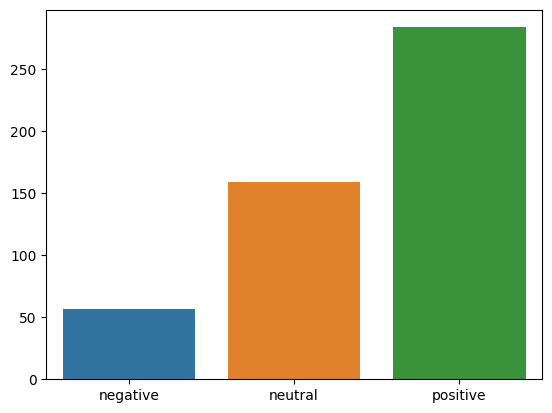

In [ ]:
import seaborn as sns

# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

The customers are generally satisfied with the room sizes, although many are still neutral and negative.

We can be even more specific when searching for reviews with the help of Pinecone's metadata filtering. For instance, we can specify a period in our query to ensure that search results only contain customer reviews for that period. This is helpful if you want to understand the customer's opinion during a specific period.

Let's do this for the same query as before. We will filter reviews from 25th December to 31st December 2015. Previously we added the `review_date` field as a timestamp to the metadata during indexing. We can convert the start and end date of the period to timestamp using the `get_timestamp` function and use a `$gte` (greater than or equal to) and a `$lte` (less than or equal to) filter to get reviews from only the selected period.

In [ ]:
# generate timestamps for start and end time of the period
start_time = get_timestamp(["2015-12-25"])[0]
end_time = get_timestamp(["2015-12-31"])[0]

<Axes: >

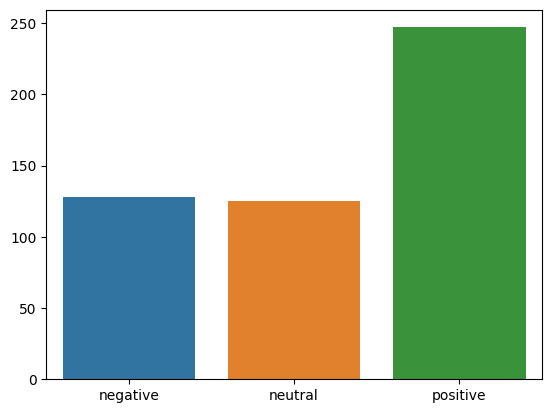

In [ ]:
query = "are the customers satisified with the room sizes of hotels in London?"
# generate query embeddings
xq = retriever.encode(query).tolist()
# query pinecone with query embeddings and the period filter
result = index.query(
    xq,
    top_k=500,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})
# get an overall count of customer sentiment
sentiment = count_sentiment(result)
# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

We have a slightly different result now. Almost the same number of customers had either a neutral or negative view of the room size during the selected period.

In [ ]:
hotels =[
    "Strand Palace Hotel",
    "Britannia International Hotel Canary Wharf",
    "Grand Royale London Hyde Park",
    "Intercontinental London The O2",
]

We will look into five main areas:
  1. Room Size
  2. Cleanliness
  3. Staff
  4. Food
  5. AC

We have a query for each of these areas below.

In [ ]:
queries = {
    "Room Size": "are customers happy with the room sizes?",
    "Cleanliness": "are customers satisfied with the cleanliness of the rooms?",
    "Staff": "did the customers like how they were treated by the staff?",
    "Food": "did the customers enjoy the food?",
    "AC": "customer opinion on the AC"
}

We need to iterate through all the hotels and run these queries for each hotel. This would give us customer reviews relevant to the selected hotel areas. After that, we count the sentiment labels and plot results for each hotel.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

hotel_sentiments = []

# iterate through the hotels
for hotel in hotels:
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the hotel filter
        xc = index.query(xq, top_k=500, include_metadata=True, filter={"hotel_name": hotel})
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            data = {
                "area": area,
                "label": k,
                "value": v
            }
            # add the data to result list
            result.append(data)
    # convert the
    hotel_sentiments.append({"hotel": hotel, "df": pd.DataFrame(result)})


Let's see what our final data look like.

In [ ]:
hotel_sentiments[0]["df"]

,area,label,value
0,Room Size,negative,127
1,Room Size,neutral,187
2,Room Size,positive,186
3,Cleanliness,negative,88
4,Cleanliness,neutral,64
5,Cleanliness,positive,348
6,Staff,negative,68
7,Staff,neutral,36
8,Staff,positive,396
9,Food,negative,95


We may now plot the final data to make inference.

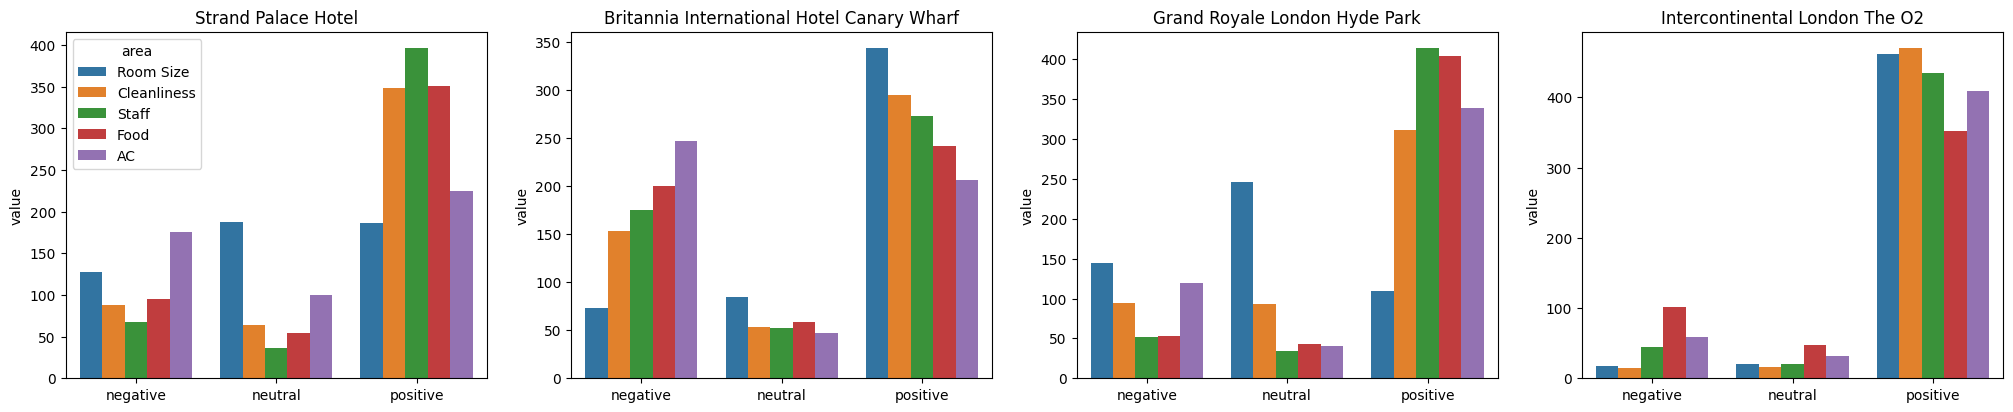

In [ ]:
# create the figure and axes to plot barchart for all hotels
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 4.5))
plt.subplots_adjust(hspace=0.25)

counter = 0
# iterate through each hotel in the list and plot a barchart
for d, ax in zip(hotel_sentiments, axs.ravel()):
    # plot barchart for each hotel
    sns.barplot(x="label", y="value", hue="area", data=d["df"], ax=ax)
    # display the hotel names
    ax.set_title(d["hotel"])
    # remove x labels
    ax.set_xlabel("")
    # remove legend from all charts except for the first one
    counter += 1
    if counter != 1: ax.get_legend().remove()
# display the full figure
plt.show()

The following observations can be made for the hotels based on the sentiment analysis:
1.  **Strand Palace Hotel:** most customers were pleased with the staff, food, and cleanliness of the rooms, while a considerable number of them were not very satisfied with the room sizes and the AC.
2.  **Britannia International Hotel Canary Wharf:** customers were quite happy with the room size, but the majority were not satisfied with the AC.
3.  **Grand Royale London Hyde Park**: the majority of the customers were not satisfied with the room size, while a good number of them were pretty satisfied with the food, staff, AC, and cleanliness of the rooms.
4.  **Intercontinental London The O2**: the majority of the customers were really happy with the selected five areas, making this hotel the best among the selected hotels.


Although we have experimented with a few selected areas, you can get creative with your queries and get the sentiment around your area of interest immediately. This approach can even be applied to live data as the Pinecone index refreshes in real-time and performs vector searches across billions of documents with millisecond latency.

# Delete Index

Delete the index if you're finished to save resources:

In [ ]:
# pinecone.delete_index(index_name)

---